In [1]:
from pymilvus import MilvusClient
from pymilvus import connections, MilvusClient, DataType
from pymilvus import AnnSearchRequest

# 云端向量数据库
CLUSTER_ENDPOINT = "https://in03-9e9fdbef8863964.serverless.ali-cn-hangzhou.cloud.zilliz.com.cn" 
TOKEN = "0b26d6c6392802bee965421c29437b0777d93c49f4871a18586ab47f1f3e98b9e805a65e8aa0a49b12ce816684cd94c8d9cd4344"

client = MilvusClient(
    uri=CLUSTER_ENDPOINT,
    token=TOKEN 
)

In [2]:
client.list_collections()

['vector_demo', 'rag_demo']

In [3]:
client.drop_collection(collection_name="vector_demo")

## RAG案例

In [4]:
import pandas as pd
from tqdm import tqdm

local_file_path = 'dataset/repoLevel/XCoLab_Conflicts.txt'

# 使用 pandas 读取本地文件
news = pd.read_csv(local_file_path, sep='\t', header=None)[0].drop_duplicates().values

# 打印前几行，查看数据是否正确读取
print(news[:10])  # 只打印前 10 个新闻标题

['concurrent_change _newline_ import org.xcolab.service.tracking.service.TrackedVisitService; _newline_  _newline_ base_content _newline_ import org.xcolab.model.tables.pojos.TrackedVisitor2User; _newline_ import org.xcolab.service.tracking.service.trackedvisitor2user.TrackedVisitService; _newline_ import org.xcolab.service.tracking.service.trackedvisitor2user.TrackedVisitor2UserService; _newline_  _newline_ incoming_change _newline_ import org.xcolab.model.tables.pojos.TrackedVisitor2User; _newline_ import org.xcolab.service.tracking.service.TrackedVisitService; _newline_ import org.xcolab.service.tracking.service.TrackedVisitor2UserService; _newline_ '
 'concurrent_change _newline_     private String _methodName506; _newline_     private String[] _methodParameterTypes506; _newline_     private String _methodName507; _newline_     private String[] _methodParameterTypes507; _newline_  _newline_ base_content _newline_     private String _methodName518; _newline_     private String[] _me

In [5]:
client.drop_collection(collection_name="vector_demo")

schema = MilvusClient.create_schema(
    auto_id=True,
    enable_dynamic_field=True,
)
schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True)
schema.add_field(field_name="chunk_content", datatype=DataType.VARCHAR, max_length=1024)
schema.add_field(field_name="chunk_sparse_embedding", datatype=DataType.SPARSE_FLOAT_VECTOR)
schema.add_field(field_name="chunk_embedding", datatype=DataType.FLOAT_VECTOR, dim=512)

index_params = MilvusClient.prepare_index_params()
index_params.add_index(
    field_name="chunk_embedding",
    metric_type="COSINE",
    index_type="AUTOINDEX",
    index_name="vector_index"
)
index_params.add_index(
    field_name="chunk_sparse_embedding",
    index_name="sparse_inverted_index",
    index_type="SPARSE_INVERTED_INDEX",
    metric_type="IP",
    params={"drop_ratio_build": 0.2},
)


client.create_collection(
    collection_name="vector_demo", 
    schema=schema, 
    index_params=index_params
)

In [6]:
from pymilvus.model.sparse.bm25.tokenizers import build_default_analyzer
from pymilvus.model.sparse import BM25EmbeddingFunction
 
analyzer = build_default_analyzer(language="en") 
bm25_ef = BM25EmbeddingFunction(analyzer)
bm25_ef.fit(news)

In [7]:
"""注释掉:已改成codebert模型嵌入"""
# from sentence_transformers import SentenceTransformer
# local_model_path = "./bge/bge-small-en-v1.5"

# # # 在线加载模型
# # from sentence_transformers import SentenceTransformer
# # model = SentenceTransformer("BAAI/bge-small-zh-v1.5")

# # 本地加载模型
# model = SentenceTransformer(local_model_path)

# import numpy as np

# # 截取或者填充到 512 维
# def ensure_vector_dimension(vector, target_dim=512):
#     if len(vector) > target_dim:
#         return vector[:target_dim]
#     elif len(vector) < target_dim:
#         return np.pad(vector, (0, target_dim - len(vector)), 'constant')
#     return vector


# for title in tqdm(news):

#     encode = model.encode(title)
#     encode = ensure_vector_dimension(encode, 512)

#     result = bm25_ef.encode_queries([title]).reshape(1, -1)
    
#     res = client.insert(
#         collection_name="vector_demo",
#         data=[
#             {
#                 "chunk_content": title,
#                 "chunk_sparse_embedding": {index: value for index, value in zip(result.indices, result.data)},
#                 "chunk_embedding": encode
#             }
#         ]
#     )

'注释掉:已改成codebert模型嵌入'

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# 加载本地 CodeBERT 模型
local_model_path = "./codebert/codebert-base"

# 加载模型和分词器
def download_or_load_model(local_model_path):
    try:
        # 尝试从本地加载模型
        tokenizer = AutoTokenizer.from_pretrained(local_model_path)
        model = AutoModel.from_pretrained(local_model_path).to("cuda" if torch.cuda.is_available() else "cpu")
        print("使用本地模型")
    except Exception as e:
        # 捕获并打印错误，帮助调试
        print(f"从本地加载模型失败，错误：{e}")
        
        # 本地不存在则从网络下载
        tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
        model = AutoModel.from_pretrained("microsoft/codebert-base").to("cuda" if torch.cuda.is_available() else "cpu")
        
        # 保存到本地
        tokenizer.save_pretrained(local_model_path)
        model.save_pretrained(local_model_path)
        print("从网络下载并保存本地模型")

    return tokenizer, model

tokenizer, model = download_or_load_model(local_model_path)

# 截取或者填充到 512 维
def ensure_vector_dimension(vector, target_dim=512):
    if len(vector) > target_dim:
        return vector[:target_dim]
    elif len(vector) < target_dim:
        return np.pad(vector, (0, target_dim - len(vector)), 'constant')
    return vector

for title in tqdm(news):
    # 使用 tokenizer 对文本进行编码
    inputs = tokenizer(title, padding=True, truncation=True, return_tensors="pt").to(model.device)
    
    # 使用 CodeBERT 获取嵌入（通过取最后一层的均值作为句子嵌入）
    with torch.no_grad():  # 禁用梯度计算
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # 获取句子级别的 embedding
    
    # 确保嵌入向量维度为 512
    encode = ensure_vector_dimension(embeddings[0], 512)

    # 处理 BM25 结果
    result = bm25_ef.encode_queries([title]).reshape(1, -1)
    
    res = client.insert(
        collection_name="vector_demo",
        data=[
            {
                "chunk_content": title[:1024],
                "chunk_sparse_embedding": {index: value for index, value in zip(result.indices, result.data)},
                "chunk_embedding": encode
            }
        ]
    )


使用本地模型


100%|██████████| 7089/7089 [27:24<00:00,  4.31it/s]


100%|██████████| 16510/16510 [00:00<00:00, 2747825.84it/s]


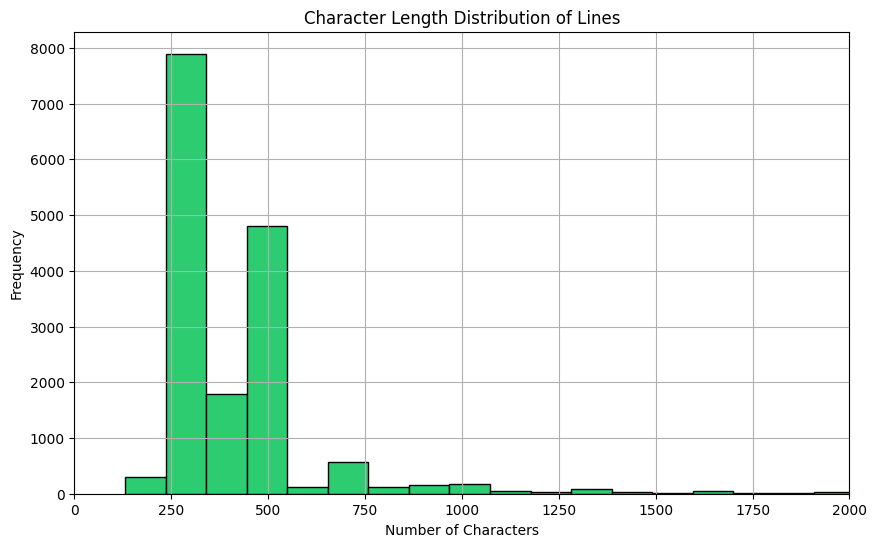

In [10]:
import matplotlib.pyplot as plt

# 读取 output.txt 文件并获取每行文本
with open("dataset/repoLevel/XCoLab_Conflicts.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# 统计每行的字符长度
line_lengths = []
for line in tqdm(lines):
    line_length = len(line.strip())  # 计算每行的字符长度，strip()去除首尾空格
    line_lengths.append(line_length)

# 绘制字符长度分布的柱状图
plt.figure(figsize=(10, 6))
plt.hist(line_lengths, bins=1000, color='#2ecc71', edgecolor='black')  # 使用新的颜色（蓝色）
plt.title("Character Length Distribution of Lines")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.xlim(0, 2000) # 设置 x 轴的范围，限制最大值为 2000
plt.grid(True)
plt.show()


100%|██████████| 16510/16510 [00:03<00:00, 4337.52it/s]


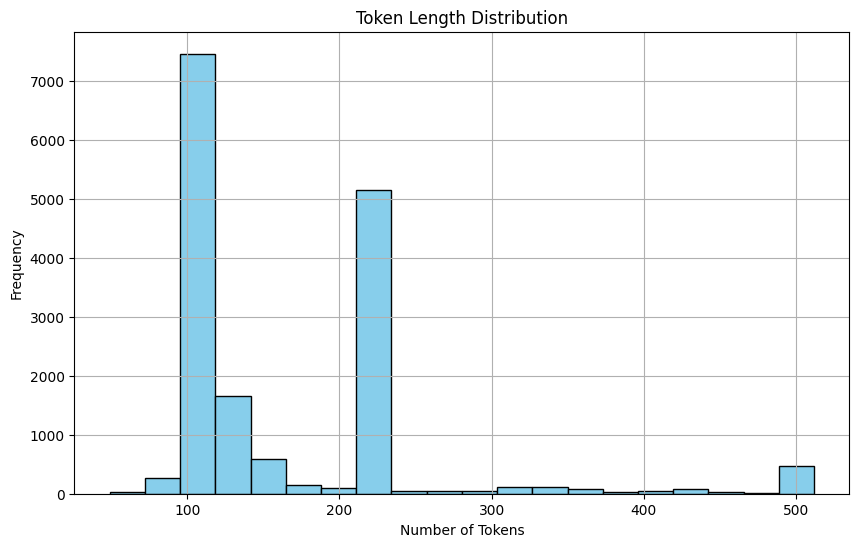

In [11]:
import matplotlib.pyplot as plt

# 读取 output.txt 文件并获取每行文本
with open("dataset/repoLevel/XCoLab_Conflicts.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# 统计每行的token数量
token_counts = []
for line in tqdm(lines):
    # 对每行文本进行tokenization
    inputs = tokenizer(line.strip(), padding=True, truncation=True, return_tensors="pt")
    token_count = len(inputs["input_ids"][0])  # 获取token数量
    token_counts.append(token_count)

# 绘制token数量分布的柱状图
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=20, color='skyblue', edgecolor='black')  # 20个bins
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [12]:
from pymilvus import (
    utility,
    FieldSchema, CollectionSchema, DataType,
    Collection, AnnSearchRequest, RRFRanker, connections,
)
from pymilvus import WeightedRanker

query = "concurrent_change _newline_ public void testGetInstance ( ) throws IllegalStateException , NamingException _newline_ base_content _newline_ public void testGetInstance ( ) throws Exception _newline_ incoming_change _newline_" 
result = bm25_ef.encode_queries([query]).reshape(1, -1)

sparse_search_params = {"metric_type": "IP"}
sparse_req = AnnSearchRequest([{index: float(value) for index, value in zip(result.indices, result.data)}],
                              "chunk_sparse_embedding", sparse_search_params, limit=2)

# 对查询使用 CodeBERT 进行编码（得到密集向量）
inputs = tokenizer(query, padding=True, truncation=True, return_tensors="pt").to(model.device)
with torch.no_grad():  # 禁用梯度计算
    outputs = model(**inputs)
    dense_embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# 确保密集向量的维度为 512
dense_embedding = ensure_vector_dimension(dense_embedding[0], 512)

dense_search_params = {"metric_type": "COSINE"}
dense_req = AnnSearchRequest([dense_embedding], "chunk_embedding", dense_search_params, limit=2)

reqs = [sparse_req, dense_req]
rerank = WeightedRanker(0.2, 0.8)
  
result = client.hybrid_search("vector_demo", reqs, ranker=rerank, limit=3, output_fields=["chunk_content",  "id"])

In [13]:
related_conflict = "\n".join([x["entity"]["chunk_content"] for x in result[0]])
related_conflictId = "\n".join([str(x["entity"]["id"]) for x in result[0]])
prompt = f"""查询：
{query}

检索结果：
{related_conflict}

对应id:
{related_conflictId}
"""
print(prompt)

查询：
concurrent_change _newline_ public void testGetInstance ( ) throws IllegalStateException , NamingException _newline_ base_content _newline_ public void testGetInstance ( ) throws Exception _newline_ incoming_change _newline_

检索结果：
concurrent_change _newline_     public static List<Pair<ContestWrapper, Date>> getAllContests() throws SystemException, PortalException { _newline_  _newline_ base_content _newline_  _newline_ incoming_change _newline_  _newline_  _newline_ 
concurrent_change _newline_     public static long linkProfilePicture(String picUrl) { _newline_  _newline_ base_content _newline_     public static long linkProfilePicture(String picUrl) throws SystemException { _newline_  _newline_ incoming_change _newline_     public static long linkProfilePicture(String path, String picUrl) throws SystemException { _newline_ 
concurrent_change _newline_         msg.append(_NO_SUCH_ENTITY_WITH_KEY); _newline_  _newline_         msg.append("contestActive="); _newline_         msg.a